In [1]:
import pandas as pd
import matplotlib.pyplot as plt
EXPORT_DIR = "data/facteurs_systemiq"



## IMPORT ET PRE TRAITEMENT

In [2]:
EXPORT_DIR = "data/facteurs_systemiq"
Z_hat = pd.read_csv(f"{EXPORT_DIR}/Z_finance.csv")
Z_hat = Z_hat.rename(columns={"Unnamed: 0": "year_quarter", "Zt": "z_t"})
Z_hat = Z_hat.rename(columns={"year_quarter": "date"})
Z_hat["date"] = pd.to_datetime(Z_hat["date"])
Z_hat = Z_hat.set_index("date")

In [3]:
# Charger le fichier Excel des macro données stationnaires
df_ts= pd.read_csv("data\macro_data\df_macro_stationary.csv")
df_ts["date"] = pd.to_datetime(df_ts["date"])
df_ts = df_ts.set_index("date")
# Fusion avec Z_hat
df_macro_stationary = df_ts.join(Z_hat, how="right")


In [4]:
df_macro_stationary

,US_GDP_Growth_Rate,US_Long_term_interest_rate,US_Oil_price,US_Unemployment_rate_hp_gap,US_Unemployment_rate_hp_gap_diff,US_Long_term_interest_rate_gap,US_Long_term_interest_rate_gap_diff,US_House_prices_residential_hp_gap,US_House_prices_residential_hp_gap_diff,US_Effective_exchange_rate_hp_gap,US_Effective_exchange_rate_hp_gap_diff,US_Central_bank_Intervention_rate_policy_interest_rate_diff,US_Equity_prices_log_hp_gap,US_Oil_price_log,US_Oil_price_log_hp_gap,US_GDP_log,US_GDP_log_hp_gap,US_GDP_log_hp_gap_diff,z_t
date,,,,,,,,,,,,,,,,,,,
2010-07-01,0.771085,2.786667,76.675000,-0.082804,0.047703,-0.166962,-0.624206,3.601028,-1.811496,3.670707,-1.309896,0.000000,-0.016866,4.339576,-0.268695,-0.259957,0.254885,-0.211838,-0.113729
2010-10-01,0.525110,2.863333,87.033160,0.165162,0.247966,-0.012209,0.154753,2.021698,-1.579330,0.003025,-3.667682,0.000000,0.050658,4.466289,-0.144801,-0.644147,-0.114129,-0.369014,0.865167
2011-01-01,-0.237205,3.460000,105.369424,-0.086385,-0.251547,0.660943,0.673152,-0.815040,-2.836737,-1.193519,-1.196544,0.000000,0.073823,4.657472,0.044519,NaN,NaN,NaN,1.182152
2011-04-01,0.676582,3.210000,117.541905,0.162673,0.249059,0.485276,-0.175667,-2.546995,-1.731955,-2.783337,-1.589818,0.000000,0.040254,4.766795,0.153504,-0.390701,0.154200,NaN,1.001547
2011-07-01,-0.022313,2.426667,113.266948,0.312513,0.149840,-0.226840,-0.712117,-2.866474,-0.319479,-2.486763,0.296575,0.000000,-0.144100,4.729747,0.118189,NaN,NaN,NaN,0.093760
2011-10-01,1.123049,2.046667,109.978629,0.163208,-0.149306,-0.540008,-0.313168,-3.210672,-0.344198,-0.365722,2.121041,0.000000,-0.068221,4.700286,0.092976,0.116047,0.675309,NaN,-0.582303
2012-01-01,0.838591,2.036667,118.427965,0.014634,-0.148574,-0.488686,0.051321,-3.692240,-0.481568,-1.250586,-0.884865,0.000000,0.015094,4.774305,0.174132,-0.176032,0.396742,-0.278567,-0.634776
2012-04-01,0.446335,1.823333,109.060407,0.166569,0.151935,-0.646998,-0.158311,-2.882534,0.809705,0.171833,1.422419,0.000000,-0.048398,4.691902,0.102071,-0.806686,-0.221996,-0.618738,0.219300
2012-07-01,0.144028,1.643333,110.133827,0.218779,0.052209,-0.778758,-0.131761,-2.474578,0.407956,-0.284492,-0.456325,0.000000,-0.022452,4.701696,0.125616,-1.937748,-1.343734,-1.121738,0.027697


Toutes les variables sont stationnaires pour le test de Kpss. US_Inflation_rate ne semble pas passer l'adf test

## MODELES SATELITES

In [5]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox, het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import adfuller

from scipy.stats import shapiro, jarque_bera
from itertools import combinations
from scipy.optimize import minimize


In [6]:
def make_lagged_features(df: pd.DataFrame, cols, lags=(0,1,2,3,4)):
    out = {}
    for c in cols:
        for L in lags:
            name = f"{c}_L{L}"
            out[name] = df[c] if L == 0 else df[c].shift(L)
    return pd.DataFrame(out, index=df.index)


In [7]:
def expand_expected_sign(expected_sign_base: dict, lags=(0,1,2,3,4)):
    exp = {}
    for var, sgn in expected_sign_base.items():
        for L in lags:
            exp[f"{var}_L{L}"] = sgn
    return exp

def sign_constraints_ok(params: pd.Series, expected_sign: dict, tol=1e-12):
    for var, sgn in expected_sign.items():
        if var in params.index:
            b = params[var]
            if abs(b) <= tol:
                continue
            if np.sign(b) != np.sign(sgn):
                return False
    return True


In [8]:
def fit_ols_hac(df, y_col, x_cols, hac_lags=4, add_const=True, min_obs=40):
    d = df[[y_col] + x_cols].dropna().copy()
    if d.shape[0] < min_obs:
        return None

    y = d[y_col].astype(float)
    X = d[x_cols].astype(float)
    if add_const:
        X = sm.add_constant(X, has_constant="add")

    try:
        ols = sm.OLS(y, X).fit()
        hac = ols.get_robustcov_results(cov_type="HAC", maxlags=hac_lags)
        return {"ols": ols, "hac": hac, "data": d, "X": X, "y": y}
    except Exception:
        return None


In [9]:
def build_admissible_model_space(
    df: pd.DataFrame,
    y_col: str,
    x_base_cols: list,
    expected_sign_base: dict,
    min_k=1,
    max_k=3,
    use_lags=True,
    lags=(0,1,2,3,4),
    verbose=True
):
    # features X (laggées ou non)
    if use_lags:
        Xfeat = make_lagged_features(df, x_base_cols, lags=lags)
        expected_sign = expand_expected_sign(expected_sign_base, lags=lags)
    else:
        Xfeat = df[x_base_cols].copy()
        expected_sign = expected_sign_base.copy()

    df_used = pd.concat([df[[y_col]], Xfeat], axis=1)

    all_models = []
    for k in range(min_k, max_k+1):
        for comb in combinations(Xfeat.columns.tolist(), k):
            all_models.append(list(comb))

    if verbose:
        print(f"Nb variables candidates: {Xfeat.shape[1]}")
        print(f"Nb modèles (combinaisons {min_k}..{max_k}): {len(all_models)}")

    rows = []
    admissible = []
    for i, x_cols in enumerate(all_models):
        fit = fit_ols_hac(df_used, y_col, x_cols, hac_lags=max(lags), min_obs=40)
        if fit is None:
            continue

        ok_sign = sign_constraints_ok(fit["ols"].params, expected_sign)
        rows.append({
            "model_id": i,
            "k": len(x_cols),
            "x_cols": x_cols,
            "ok_sign": ok_sign,
            "aic": fit["ols"].aic,
            "bic": fit["ols"].bic,
            "r2_adj": fit["ols"].rsquared_adj
        })
        if ok_sign:
            admissible.append({"name": f"m{i}", "x": x_cols})

    summary = pd.DataFrame(rows).sort_values(["ok_sign","bic"], ascending=[False, True])
    if verbose and not summary.empty:
        print("OK_sign:", int(summary["ok_sign"].sum()), "/", summary.shape[0])

    return summary, admissible, df_used


In [10]:
import numpy as np
import pandas as pd
from itertools import combinations

def build_admissible_model_space(
    df: pd.DataFrame,
    y_col: str,
    x_base_cols: list,
    min_k=1,
    max_k=3,
    use_lags=True,
    lags=(1,2,3,4),
    verbose=True
):
    # features X (laggées ou non)
    if use_lags:
        Xfeat = make_lagged_features(df, x_base_cols, lags=lags)
    else:
        Xfeat = df[x_base_cols].copy()

    df_used = pd.concat([df[[y_col]], Xfeat], axis=1)

    all_models = []
    for k in range(min_k, max_k + 1):
        for comb in combinations(Xfeat.columns.tolist(), k):
            all_models.append(list(comb))

    if verbose:
        print(f"Nb variables candidates: {Xfeat.shape[1]}")
        print(f"Nb modèles (combinaisons {min_k}..{max_k}): {len(all_models)}")

    rows = []
    admissible = []

    # Pour avoir des colonnes stables (même si une variable n'est pas dans le modèle)
    all_possible_terms = ["const"] + Xfeat.columns.tolist()

    for i, x_cols in enumerate(all_models):
        fit = fit_ols_hac(df_used, y_col, x_cols, hac_lags=max(lags), min_obs=40)
        if fit is None:
            continue

        ols = fit["ols"]

        # Coeffs du modèle (pandas Series indexée par nom de variable, ex: "const", "X1", ...)
        params = ols.params

        # On crée un dict de coeffs "complet" (NaN si la variable n'est pas dans le modèle)
        coef_dict = {f"coef_{term}": np.nan for term in all_possible_terms}
        for term, val in params.items():
            coef_dict[f"coef_{term}"] = float(val)

        rows.append({
            "model_id": i,
            "k": len(x_cols),
            "x_cols": x_cols,
            "aic": ols.aic,
            "bic": ols.bic,
            "r2_adj": ols.rsquared_adj,
            **coef_dict
        })

        admissible.append({"name": f"m{i}", "x": x_cols})

    summary = pd.DataFrame(rows).sort_values(["r2_adj"], ascending=[False])
    return summary, admissible, df_used

In [11]:
x_base_cols=df_ts.columns.tolist()


In [12]:
df_macro_stationary.head()

,US_GDP_Growth_Rate,US_Long_term_interest_rate,US_Oil_price,US_Unemployment_rate_hp_gap,US_Unemployment_rate_hp_gap_diff,US_Long_term_interest_rate_gap,US_Long_term_interest_rate_gap_diff,US_House_prices_residential_hp_gap,US_House_prices_residential_hp_gap_diff,US_Effective_exchange_rate_hp_gap,US_Effective_exchange_rate_hp_gap_diff,US_Central_bank_Intervention_rate_policy_interest_rate_diff,US_Equity_prices_log_hp_gap,US_Oil_price_log,US_Oil_price_log_hp_gap,US_GDP_log,US_GDP_log_hp_gap,US_GDP_log_hp_gap_diff,z_t
date,,,,,,,,,,,,,,,,,,,
2010-07-01,0.771085,2.786667,76.675000,-0.082804,0.047703,-0.166962,-0.624206,3.601028,-1.811496,3.670707,-1.309896,0.0,-0.016866,4.339576,-0.268695,-0.259957,0.254885,-0.211838,-0.113729
2010-10-01,0.525110,2.863333,87.033160,0.165162,0.247966,-0.012209,0.154753,2.021698,-1.579330,0.003025,-3.667682,0.0,0.050658,4.466289,-0.144801,-0.644147,-0.114129,-0.369014,0.865167
2011-01-01,-0.237205,3.460000,105.369424,-0.086385,-0.251547,0.660943,0.673152,-0.815040,-2.836737,-1.193519,-1.196544,0.0,0.073823,4.657472,0.044519,NaN,NaN,NaN,1.182152
2011-04-01,0.676582,3.210000,117.541905,0.162673,0.249059,0.485276,-0.175667,-2.546995,-1.731955,-2.783337,-1.589818,0.0,0.040254,4.766795,0.153504,-0.390701,0.154200,NaN,1.001547
2011-07-01,-0.022313,2.426667,113.266948,0.312513,0.149840,-0.226840,-0.712117,-2.866474,-0.319479,-2.486763,0.296575,0.0,-0.144100,4.729747,0.118189,NaN,NaN,NaN,0.093760


In [ ]:
summary, admissible, df_used= build_admissible_model_space(df_macro_stationary,
    y_col='z_t',
    x_base_cols=x_base_cols,
    min_k=1,
    max_k=3,
    use_lags=True,
    lags=(1,2,3,4),
    verbose=True
)

Nb variables candidates: 72
Nb modèles (combinaisons 1..3): 62268


In [ ]:
summary

,model_id,k,x_cols,aic,bic,r2_adj,coef_const,coef_US_GDP_Growth_Rate_L1,coef_US_GDP_Growth_Rate_L2,coef_US_GDP_Growth_Rate_L3,...,coef_US_GDP_log_L3,coef_US_GDP_log_L4,coef_US_GDP_log_hp_gap_L1,coef_US_GDP_log_hp_gap_L2,coef_US_GDP_log_hp_gap_L3,coef_US_GDP_log_hp_gap_L4,coef_US_GDP_log_hp_gap_diff_L1,coef_US_GDP_log_hp_gap_diff_L2,coef_US_GDP_log_hp_gap_diff_L3,coef_US_GDP_log_hp_gap_diff_L4
37605,43536,3,"[US_Long_term_interest_rate_gap_L3, US_Central...",64.463372,71.508173,0.668054,-0.147656,NaN,NaN,NaN,...,NaN,NaN,0.263163,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24968,28557,3,"[US_Unemployment_rate_hp_gap_L1, US_Long_term_...",71.909626,79.476907,0.653155,-0.090612,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37601,43532,3,"[US_Long_term_interest_rate_gap_L3, US_Central...",66.620682,73.665483,0.650976,-0.051520,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37597,43528,3,"[US_Long_term_interest_rate_gap_L3, US_Central...",74.354984,81.922265,0.635406,-0.051902,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38601,44754,3,"[US_Long_term_interest_rate_gap_L4, US_Equity_...",69.032154,76.076955,0.630843,-0.029185,NaN,NaN,NaN,...,NaN,NaN,0.128753,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24046,27443,3,"[US_Oil_price_L4, US_Effective_exchange_rate_h...",111.803790,118.754469,-0.077976,0.054033,NaN,NaN,NaN,...,-0.032163,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18240,20777,3,"[US_Oil_price_L1, US_Oil_price_L4, US_GDP_log_L3]",111.810484,118.761163,-0.078147,0.025889,NaN,NaN,NaN,...,-0.025380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24211,27632,3,"[US_Oil_price_L4, US_Effective_exchange_rate_h...",111.816657,118.767336,-0.078306,0.037756,NaN,NaN,NaN,...,-0.024815,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19883,22668,3,"[US_Oil_price_L2, US_Oil_price_L4, US_GDP_log_L3]",111.817392,118.768071,-0.078325,0.051897,NaN,NaN,NaN,...,-0.021851,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
def residual_diagnostics(fit_dict, lb_lags=12, alpha=0.05):
    ols = fit_dict["ols"]
    resid = ols.resid

    # ✅ exog réellement utilisé par le modèle (inclut la constante si elle est dans le modèle)
    X = ols.model.exog

    lb = acorr_ljungbox(resid, lags=[lb_lags], return_df=True)
    lb_p = float(lb["lb_pvalue"].iloc[0])

    bp_stat, bp_p, _, _ = het_breuschpagan(resid, X)

    sh_p = shapiro(resid)[1] if len(resid) <= 5000 else np.nan
    jb_p = jarque_bera(resid)[1]

    adf_p = adfuller(resid.dropna(), autolag="AIC")[1] if resid.notna().sum() > 20 else np.nan
    dw = durbin_watson(resid)

    return {
        "n": int(len(resid)),
        "lb_pvalue": lb_p,
        "bp_pvalue": float(bp_p),
        "shapiro_pvalue": float(sh_p) if not np.isnan(sh_p) else np.nan,
        "jb_pvalue": float(jb_p),
        "adf_resid_pvalue": float(adf_p) if not np.isnan(adf_p) else np.nan,
        "dw": float(dw),
        "LB_ok_5pct": (lb_p > alpha),
        "BP_ok_5pct": (bp_p > alpha),
    }




In [ ]:
import numpy as np

from statsmodels.stats.stattools import jarque_bera
from statsmodels.tsa.stattools import adfuller, kpss


def normality_ok(resid, alpha=0.05, method="jb"):
    """
    Test de normalité des résidus.
    Retourne dict avec p-value + bool.
    method: "jb" (Jarque-Bera) par défaut.
    """
    resid = np.asarray(resid)
    resid = resid[~np.isnan(resid)]

    if resid.size < 8:  # JB pas super stable très petit n
        return {"norm_method": method, "norm_pvalue": np.nan, "norm_ok": False}

    if method.lower() == "jb":
        jb_stat, jb_pvalue, skew, kurt = jarque_bera(resid)
        return {
            "norm_method": "JB",
            "norm_stat": float(jb_stat),
            "norm_pvalue": float(jb_pvalue),
            "norm_ok": bool(jb_pvalue > alpha),
            "skew": float(skew),
            "kurtosis": float(kurt),
        }

    raise ValueError("method must be 'jb'")


def stationarity_ok(resid, alpha=0.05, method="adf", kpss_regression="c"):
    """
    Test de stationnarité des résidus.
    method:
      - "adf": H0 = racine unitaire (non-stationnaire) => ok si pvalue < alpha
      - "kpss": H0 = stationnaire => ok si pvalue > alpha
      - "both": exige ADF ok ET KPSS ok (plus strict)
    """
    resid = np.asarray(resid)
    resid = resid[~np.isnan(resid)]

    if resid.size < 12:
        return {
            "stat_method": method.upper(),
            "stat_ok": False,
            "adf_pvalue": np.nan,
            "kpss_pvalue": np.nan,
        }

    out = {"stat_method": method.upper()}

    if method.lower() in ("adf", "both"):
        # autolag='AIC' est un bon défaut
        adf = adfuller(resid, autolag="AIC")
        adf_stat, adf_pvalue = adf[0], adf[1]
        out.update({"adf_stat": float(adf_stat), "adf_pvalue": float(adf_pvalue)})
        adf_ok = (adf_pvalue < alpha)
    else:
        adf_ok = True

    if method.lower() in ("kpss", "both"):
        # Attention: KPSS peut warning si série très stationnaire; on attrape et garde pvalue
        try:
            kpss_res = kpss(resid, regression=kpss_regression, nlags="auto")
            kpss_stat, kpss_pvalue = kpss_res[0], kpss_res[1]
        except Exception:
            kpss_stat, kpss_pvalue = np.nan, np.nan
        out.update({"kpss_stat": float(kpss_stat) if np.isfinite(kpss_stat) else np.nan,
                    "kpss_pvalue": float(kpss_pvalue) if np.isfinite(kpss_pvalue) else np.nan})
        kpss_ok = (np.isnan(kpss_pvalue) == False) and (kpss_pvalue > alpha)
    else:
        kpss_ok = True

    if method.lower() == "adf":
        out["stat_ok"] = bool(adf_ok)
    elif method.lower() == "kpss":
        out["stat_ok"] = bool(kpss_ok)
    elif method.lower() == "both":
        out["stat_ok"] = bool(adf_ok and kpss_ok)
    else:
        raise ValueError("method must be 'adf', 'kpss', or 'both'")

    return out


def hac_significance_ok(hac_result, x_cols, alpha=0.05, min_sig=1, exclude_const=True):
    """
    Vérifie la significativité individuelle des coefficients (p-values HAC).
    - hac_result: typiquement fit["hac"] (statsmodels RegressionResults robustes)
    - x_cols: liste des variables explicatives (sans y)
    - exclude_const: ignore 'const' si présent
    - min_sig: nombre minimum de coefficients significatifs requis
    """
    # pvalues est une Series indexée par noms de params
    pvals = hac_result.pvalues

    params = list(pvals.index)

    if exclude_const and "const" in params:
        params = [p for p in params if p != "const"]

    # Si tes x_cols sont les vrais noms dans la régression, on restreint à ceux-là
    # (sinon on prend tout sauf const)
    if x_cols is not None and len(x_cols) > 0:
        # garde seulement ceux présents (robuste aux noms)
        params = [p for p in params if p in set(x_cols)]

    sig_count = int(np.sum(pvals.loc[params] < alpha)) if len(params) else 0

    return (sig_count >= min_sig)

In [ ]:
def residual_diagnostics_full(
    fit,
    lb_lags=12,
    alpha=0.05,
    normality=True,
    norm_alpha=0.05,
    norm_method="jb",
    stationarity=True,
    stat_alpha=0.05,
    stat_method="adf",   # "adf" / "kpss" / "both"
):
    """
    Combine tes diagnostics existants + normalité + stationnarité.
    """
    diag = residual_diagnostics(fit, lb_lags=lb_lags, alpha=alpha)

    resid = fit["ols"].resid

    if normality:
        diag.update(normality_ok(resid, alpha=norm_alpha, method=norm_method))
    else:
        diag.update({"norm_ok": True, "norm_pvalue": np.nan, "norm_method": None})

    if stationarity:
        diag.update(stationarity_ok(resid, alpha=stat_alpha, method=stat_method))
    else:
        diag.update({"stat_ok": True, "adf_pvalue": np.nan, "kpss_pvalue": np.nan, "stat_method": None})

    return diag

In [ ]:
def hac_significance_ok(hac_res, x_cols, alpha=0.05, min_sig=1):
    pvals = pd.Series(hac_res.pvalues, index=hac_res.model.exog_names)
    vars_in = [v for v in x_cols if v in pvals.index]
    if not vars_in:
        return False
    return int((pvals[vars_in] < alpha).sum()) >= min_sig

def build_candidate_pool_and_filter(
    df, y_col, candidate_models,
    hac_lags=4, lb_lags=12, alpha=0.05,
    require_sig=False, sig_alpha=0.05, min_sig=1,
    enforce_bp=False, enforce_lb=True,
    enforce_norm=False, norm_alpha=0.05, norm_method="jb",
    enforce_stat=False, stat_alpha=0.05, stat_method="adf",
):
    summary_rows = []

    for m in candidate_models:
        x_cols = m["x"]
        fit = fit_ols_hac(df, y_col, x_cols, hac_lags=hac_lags)
        if fit is None:
            continue

        diag = residual_diagnostics_full(
            fit,
            lb_lags=lb_lags,
            alpha=alpha,
            normality=enforce_norm,
            norm_alpha=norm_alpha,
            norm_method=norm_method,
            stationarity=enforce_stat,
            stat_alpha=stat_alpha,
            stat_method=stat_method,
        )

        ok_sig = True
        if require_sig:
            ok_sig = hac_significance_ok(
                fit["hac"], x_cols, alpha=sig_alpha, min_sig=min_sig
            )

        ok_lb = diag.get("LB_ok_5pct", True) if enforce_lb else True
        ok_bp = diag.get("BP_ok_5pct", True) if enforce_bp else True
        ok_norm = diag.get("norm_ok", True) if enforce_norm else True
        ok_stat = diag.get("stat_ok", True) if enforce_stat else True

        ok = ok_sig and ok_lb and ok_bp and ok_norm and ok_stat

        summary_rows.append({
            "model": m.get("name", str(tuple(x_cols))),
            "x_cols": tuple(x_cols),
            "ok": ok,
            "k": len(x_cols),
            "aic": fit["ols"].aic,
            "bic": fit["ols"].bic,
            "r2_adj": fit["ols"].rsquared_adj,
            "ok_lb": ok_lb,
            "ok_bp": ok_bp,
            "ok_sig": ok_sig,
            "ok_norm": ok_norm,
            "ok_stat": ok_stat,
            **diag
        })

    summary = pd.DataFrame(summary_rows)

    if summary.empty:
        return [], summary

    summary_ok = summary[summary["ok"]].copy()
    summary_top = summary_ok.sort_values("aic")

    kept = [
        m for m in candidate_models
        if tuple(m["x"]) in set(summary_top["x_cols"])
    ]

    summary = summary.sort_values(["ok", "aic"], ascending=[False, True])

    return kept, summary

In [ ]:
y_col='z_t'
x_cols = [c for c in df_used.columns if c != "z_t"]

kept, summary1= build_candidate_pool_and_filter(
    df_used, y_col, admissible,
    hac_lags=4, lb_lags=12, alpha=0.05,
    require_sig=True, sig_alpha=0.05, min_sig=1,
    enforce_bp=True, enforce_lb=True,
    enforce_norm=True, norm_alpha=0.05, norm_method="jb",
    enforce_stat=True, stat_alpha=0.05, stat_method="adf",
)


In [ ]:
summary1

,model,x_cols,ok,k,aic,bic,r2_adj,ok_lb,ok_bp,ok_sig,...,norm_method,norm_stat,norm_pvalue,norm_ok,skew,kurtosis,stat_method,adf_stat,adf_pvalue,stat_ok
37605,m43536,"(US_Long_term_interest_rate_gap_L3, US_Central...",True,3,64.463372,71.508173,0.668054,True,True,True,...,JB,0.648488,0.723074,True,0.162519,2.493742,ADF,-4.343387,0.000373,True
37601,m43532,"(US_Long_term_interest_rate_gap_L3, US_Central...",True,3,66.620682,73.665483,0.650976,True,True,True,...,JB,0.721925,0.697005,True,0.059733,2.376572,ADF,-4.354453,0.000357,True
37286,m43169,"(US_Long_term_interest_rate_gap_L3, US_House_p...",True,3,68.288970,75.239648,0.615953,True,True,True,...,JB,0.043658,0.978407,True,-0.037557,2.861055,ADF,-4.103369,0.000956,True
37290,m43173,"(US_Long_term_interest_rate_gap_L3, US_House_p...",True,3,68.518803,75.469481,0.613846,True,True,True,...,JB,0.291430,0.864404,True,-0.161616,2.750897,ADF,-4.013163,0.001343,True
38604,m44757,"(US_Long_term_interest_rate_gap_L4, US_Equity_...",True,3,70.369181,77.319860,0.596453,True,True,True,...,JB,1.957198,0.375837,True,0.440159,3.586036,ADF,-3.706647,0.004021,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31038,m35658,"(US_Unemployment_rate_hp_gap_diff_L1, US_Centr...",False,3,130.387481,138.114783,-0.056333,False,True,False,...,JB,0.225224,0.893497,True,0.001481,3.325544,ADF,-2.998391,0.035045,True
46933,m55348,"(US_Effective_exchange_rate_hp_gap_L1, US_Cent...",False,3,130.403869,138.131172,-0.056673,False,True,False,...,JB,0.227866,0.892318,True,-0.051675,3.310725,ADF,-2.985231,0.036297,True
4070,m4490,"(US_GDP_Growth_Rate_L1, US_Effective_exchange_...",False,3,130.425313,138.152615,-0.057117,False,True,False,...,JB,0.146998,0.929137,True,-0.011943,3.261925,ADF,-3.133813,0.024150,True
4074,m4494,"(US_GDP_Growth_Rate_L1, US_Effective_exchange_...",False,3,130.506636,138.233939,-0.058804,False,True,False,...,JB,0.397410,0.819792,True,-0.042687,3.423943,ADF,-2.879190,0.047822,True


In [ ]:
len(kept)

56

In [ ]:
def solve_simplex_weights_slsqp(Y, y):
    """
    Min ||y - Yw||^2 s.c w>=0, sum w = 1
    """
    T, M = Y.shape
    w0 = np.ones(M) / M

    cons = (
        {"type": "eq", "fun": lambda w: np.sum(w) - 1.0},
    )
    bounds = [(0.0, 1.0)] * M

    def obj(w):
        r = y - Y @ w
        return float(r.T @ r)

    res = minimize(obj, w0, method="SLSQP", bounds=bounds, constraints=cons)
    if not res.success:
        return None
    return res.x


In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# ---------------------------
# ETAPE 1 : prédictions LOO
# ---------------------------

def loo_pred_one_model(df, y_col, x_cols, hac_lags=4, add_const=True, min_obs=40):
    """
    Pour UN modèle : calcule f_k^{(-t)}(x_t) pour chaque t (LOO).
    Retour: Series indexée comme df.index (NaN si non calculable)
    """
    d = df[[y_col] + x_cols].copy()
    d = d.dropna(subset=[y_col] + x_cols)  # LOO défini seulement si y et X existent

    yhat_loo = pd.Series(index=df.index, dtype=float)

    for t in d.index:
        d_minus = d.drop(index=t)
        if len(d_minus) < min_obs:
            continue

        fit = fit_ols_hac(d_minus, y_col, x_cols, hac_lags=hac_lags, min_obs=min_obs)
        if fit is None:
            continue

        ols = fit["ols"]
        x_t = d.loc[t, x_cols].astype(float)

        X_t = pd.DataFrame([x_t.values], columns=x_cols)
        if add_const:
            X_t = sm.add_constant(X_t, has_constant="add")

        yhat_loo.loc[t] = float(ols.predict(X_t).iloc[0])

    return yhat_loo


def build_P_loo(df, y_col, kept_models, hac_lags=4, add_const=True, min_obs=40):
    """
    Construit la matrice P_loo : colonnes = modèles, lignes = dates, valeurs = prédictions LOO.
    """
    preds = {}
    for i, m in enumerate(kept_models):
        name = m.get("name", f"m{i}")
        preds[name] = loo_pred_one_model(
            df=df, y_col=y_col, x_cols=m["x"],
            hac_lags=hac_lags, add_const=add_const, min_obs=min_obs
        )
    return pd.DataFrame(preds)


# ---------------------------
# ETAPE 2 : apprendre les poids (simplex)
# ---------------------------

def learn_simplex_weights_from_loo(df, y_col, P_loo):
    """
    Apprend w = argmin sum_t (y_t - sum_k w_k P_loo[t,k])^2
    s.c. sum w_k = 1 et w_k >= 0
    """
    d_w = pd.concat([df[[y_col]], P_loo], axis=1).dropna()  # intersection où tout existe

    y = d_w[y_col].values
    Y = d_w[P_loo.columns].values

    w = solve_simplex_weights_slsqp(Y, y)
    if w is None:
        raise RuntimeError("Le solveur des poids a échoué.")

    weights = pd.Series(w, index=P_loo.columns, name="w_opt")
    return weights, d_w


# ---------------------------
# ETAPE 3 : refit full sample + prédictions finales + JMA
# ---------------------------

def full_fit_predict_one_model(df, y_col, x_cols, hac_lags=4, add_const=True, min_obs=40):
    """
    Refit le modèle sur tout l'échantillon (dropna sur y et X), puis prédit partout où X existe.
    """
    d_fit = df[[y_col] + x_cols].copy().dropna(subset=[y_col] + x_cols)

    fit = fit_ols_hac(d_fit, y_col, x_cols, hac_lags=hac_lags, min_obs=min_obs)
    if fit is None:
        return pd.Series(index=df.index, dtype=float)

    ols = fit["ols"]

    d_pred = df[x_cols].copy().dropna(subset=x_cols)
    X_pred = d_pred.astype(float)
    if add_const:
        X_pred = sm.add_constant(X_pred, has_constant="add")

    yhat = pd.Series(index=df.index, dtype=float)
    yhat.loc[d_pred.index] = ols.predict(X_pred).values
    return yhat


def jma_step_by_step(df, y_col, kept_models, hac_lags=4, add_const=True, min_obs=40):
    """
    Pipeline complet en 3 étapes (LOO -> poids -> refit full -> prédiction JMA).
    """
    # ETAPE 1
    P_loo = build_P_loo(df, y_col, kept_models, hac_lags=hac_lags, add_const=add_const, min_obs=min_obs)

    # ETAPE 2
    weights, oos_frame = learn_simplex_weights_from_loo(df, y_col, P_loo)

    # ETAPE 3
    preds_full = {}
    for i, m in enumerate(kept_models):
        name = m.get("name", f"m{i}")
        preds_full[name] = full_fit_predict_one_model(
            df=df, y_col=y_col, x_cols=m["x"],
            hac_lags=hac_lags, add_const=add_const, min_obs=min_obs
        )
    P_full = pd.DataFrame(preds_full)

    # prédiction JMA finale (dates où tous les modèles ont une prédiction)
    d_pred = P_full.dropna()
    yhat_jma = pd.Series(d_pred.values @ weights.values, index=d_pred.index, name="yhat_jma")

    # modèles finaux (poids > 0)
    selected_weights = weights[weights > 0].sort_values(ascending=False)
    selected_models = [
        {"name": m.get("name", f"m{i}"), "x": m["x"], "weight": float(selected_weights[m.get("name", f"m{i}")])}
        for i, m in enumerate(kept_models)
        if m.get("name", f"m{i}") in selected_weights.index
    ]

    return {
        "P_loo": P_loo,                 # étape 1
        "weights_opt": weights,         # étape 2
        "selected_weights": selected_weights,
        "selected_models": selected_models,
        "P_full": P_full,               # étape 3
        "yhat_jma": yhat_jma,
        "oos_frame_weights": oos_frame
    }

In [ ]:
res= jma_step_by_step(df_used, y_col, kept, hac_lags=4, add_const=True, min_obs=40)

In [ ]:
summary1

,model,x_cols,ok,k,aic,bic,r2_adj,ok_lb,ok_bp,ok_sig,...,norm_method,norm_stat,norm_pvalue,norm_ok,skew,kurtosis,stat_method,adf_stat,adf_pvalue,stat_ok
37605,m43536,"(US_Long_term_interest_rate_gap_L3, US_Central...",True,3,64.463372,71.508173,0.668054,True,True,True,...,JB,0.648488,0.723074,True,0.162519,2.493742,ADF,-4.343387,0.000373,True
37601,m43532,"(US_Long_term_interest_rate_gap_L3, US_Central...",True,3,66.620682,73.665483,0.650976,True,True,True,...,JB,0.721925,0.697005,True,0.059733,2.376572,ADF,-4.354453,0.000357,True
37286,m43169,"(US_Long_term_interest_rate_gap_L3, US_House_p...",True,3,68.288970,75.239648,0.615953,True,True,True,...,JB,0.043658,0.978407,True,-0.037557,2.861055,ADF,-4.103369,0.000956,True
37290,m43173,"(US_Long_term_interest_rate_gap_L3, US_House_p...",True,3,68.518803,75.469481,0.613846,True,True,True,...,JB,0.291430,0.864404,True,-0.161616,2.750897,ADF,-4.013163,0.001343,True
38604,m44757,"(US_Long_term_interest_rate_gap_L4, US_Equity_...",True,3,70.369181,77.319860,0.596453,True,True,True,...,JB,1.957198,0.375837,True,0.440159,3.586036,ADF,-3.706647,0.004021,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31038,m35658,"(US_Unemployment_rate_hp_gap_diff_L1, US_Centr...",False,3,130.387481,138.114783,-0.056333,False,True,False,...,JB,0.225224,0.893497,True,0.001481,3.325544,ADF,-2.998391,0.035045,True
46933,m55348,"(US_Effective_exchange_rate_hp_gap_L1, US_Cent...",False,3,130.403869,138.131172,-0.056673,False,True,False,...,JB,0.227866,0.892318,True,-0.051675,3.310725,ADF,-2.985231,0.036297,True
4070,m4490,"(US_GDP_Growth_Rate_L1, US_Effective_exchange_...",False,3,130.425313,138.152615,-0.057117,False,True,False,...,JB,0.146998,0.929137,True,-0.011943,3.261925,ADF,-3.133813,0.024150,True
4074,m4494,"(US_GDP_Growth_Rate_L1, US_Effective_exchange_...",False,3,130.506636,138.233939,-0.058804,False,True,False,...,JB,0.397410,0.819792,True,-0.042687,3.423943,ADF,-2.879190,0.047822,True


In [ ]:

y_meta_col=res["yhat_jma"]
best_row = (
    summary1
    .query("ok == True")
    .sort_values("aic", ascending=True)
    .iloc[0]
)

best_model_name = best_row["model"]
best_model_name
best_model = next(
    m for m in admissible if m["name"] == best_model_name
)

x_best = best_model["x"]

df2 = df_used[[y_col] + x_best].dropna()

fit = fit_ols_hac(df2, y_col, x_best, hac_lags=4)
ols = fit["ols"]

X = df2[x_best].astype(float)
X = sm.add_constant(X, has_constant="add")
yhat_best = pd.Series(ols.predict(X), index=df2.index, name="yhat_best")

y_indiv_col=yhat_best




In [ ]:
len

<function len(obj, /)>

In [ ]:
best_row

model                                                          m13870
x_cols              (US_Long_term_interest_rate_L1, US_Effective_e...
ok                                                               True
k                                                                   3
aic                                                        116.323174
bic                                                        124.050477
r2_adj                                                       0.198257
ok_lb                                                            True
ok_bp                                                            True
ok_sig                                                           True
ok_norm                                                          True
ok_stat                                                          True
n                                                                  51
lb_pvalue                                                    0.069471
bp_pvalue           

In [ ]:
summary

,model_id,k,x_cols,aic,bic,r2_adj,coef_const,coef_US_GDP_Growth_Rate_L1,coef_US_GDP_Growth_Rate_L2,coef_US_GDP_Growth_Rate_L3,...,coef_US_GDP_log_L3,coef_US_GDP_log_L4,coef_US_GDP_log_hp_gap_L1,coef_US_GDP_log_hp_gap_L2,coef_US_GDP_log_hp_gap_L3,coef_US_GDP_log_hp_gap_L4,coef_US_GDP_log_hp_gap_diff_L1,coef_US_GDP_log_hp_gap_diff_L2,coef_US_GDP_log_hp_gap_diff_L3,coef_US_GDP_log_hp_gap_diff_L4
37605,43536,3,"[US_Long_term_interest_rate_gap_L3, US_Central...",64.463372,71.508173,0.668054,-0.147656,NaN,NaN,NaN,...,NaN,NaN,0.263163,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24968,28557,3,"[US_Unemployment_rate_hp_gap_L1, US_Long_term_...",71.909626,79.476907,0.653155,-0.090612,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37601,43532,3,"[US_Long_term_interest_rate_gap_L3, US_Central...",66.620682,73.665483,0.650976,-0.051520,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37597,43528,3,"[US_Long_term_interest_rate_gap_L3, US_Central...",74.354984,81.922265,0.635406,-0.051902,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38601,44754,3,"[US_Long_term_interest_rate_gap_L4, US_Equity_...",69.032154,76.076955,0.630843,-0.029185,NaN,NaN,NaN,...,NaN,NaN,0.128753,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24046,27443,3,"[US_Oil_price_L4, US_Effective_exchange_rate_h...",111.803790,118.754469,-0.077976,0.054033,NaN,NaN,NaN,...,-0.032163,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18240,20777,3,"[US_Oil_price_L1, US_Oil_price_L4, US_GDP_log_L3]",111.810484,118.761163,-0.078147,0.025889,NaN,NaN,NaN,...,-0.025380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24211,27632,3,"[US_Oil_price_L4, US_Effective_exchange_rate_h...",111.816657,118.767336,-0.078306,0.037756,NaN,NaN,NaN,...,-0.024815,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19883,22668,3,"[US_Oil_price_L2, US_Oil_price_L4, US_GDP_log_L3]",111.817392,118.768071,-0.078325,0.051897,NaN,NaN,NaN,...,-0.021851,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


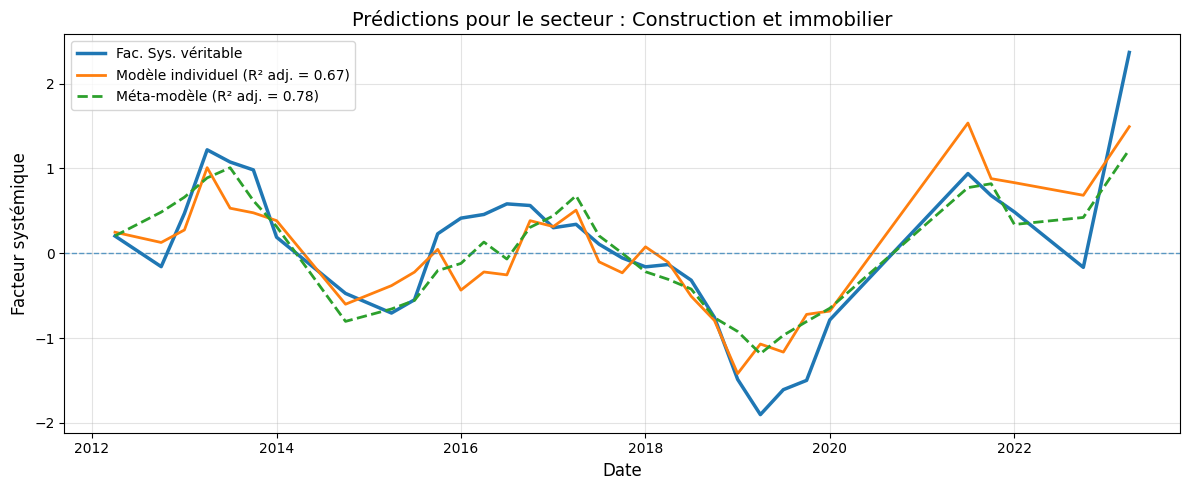

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_predictions_like_example(
    df,
    date_col="date",          # colonne date (datetime ou convertible)
    y_true_col="y_true",      # facteur systémique "véritable"
    y_indiv_col="y_indiv",    # prédiction d'un modèle individuel
    y_meta_col="y_meta",      # prédiction du méta-modèle (stacking/JMA)
    sector_name="Extractions_primaires",
    r2_indiv=None,            # si None -> calculé
    r2_meta=None,             # si None -> calculé
    title_prefix="Prédictions pour le secteur : ",
    figsize=(12, 5),
    savepath=None
):
    """
    Reproduit un graphe proche de ton exemple:
    - noir: y_true
    - bleu: y_indiv
    - rouge pointillé: y_meta
    - ligne horizontale y=0 en gris pointillé
    - légende avec R² adj (ici on met R² simple; si tu veux l'ajusté, passe-le via r2_*)

    df doit contenir au minimum: date_col, y_true_col, y_indiv_col, y_meta_col.
    """
    d = df[[date_col, y_true_col, y_indiv_col, y_meta_col]].copy()
    d[date_col] = pd.to_datetime(d[date_col], errors="coerce")
    d = d.dropna().sort_values(date_col)

    y_true = d[y_true_col].astype(float).values
    y_ind  = d[y_indiv_col].astype(float).values
    y_meta = d[y_meta_col].astype(float).values

    def r2(y, yhat):
        if len(y) < 2:
            return np.nan
        sse = np.sum((y - yhat) ** 2)
        sst = np.sum((y - np.mean(y)) ** 2)
        return np.nan if sst == 0 else 1 - sse / sst

    if r2_indiv is None:
        r2_indiv = r2(y_true, y_ind)
    if r2_meta is None:
        r2_meta = r2(y_true, y_meta)

    plt.figure(figsize=figsize)
    plt.plot(d[date_col], y_true, linewidth=2.5, label="Fac. Sys. véritable")
    plt.plot(d[date_col], y_ind,  linewidth=2.0, label=f"Modèle individuel (R² adj. = {r2_indiv:.2f})")
    plt.plot(d[date_col], y_meta, linewidth=2.0, linestyle="--",
             label=f"Méta-modèle (R² adj. = {r2_meta:.2f})")

    plt.axhline(0, linestyle="--", linewidth=1.0, alpha=0.7)
    plt.grid(True, alpha=0.35)

    plt.title(f"{title_prefix}{sector_name}", fontsize=14)
    plt.ylabel("Facteur systémique", fontsize=12)
    plt.xlabel("Date", fontsize=12)
    plt.legend(loc="upper left", frameon=True)

    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=200, bbox_inches="tight")
    plt.show()


# ==========================
# EXEMPLE D’UTILISATION
# ==========================
# Tu peux construire df_plot à partir de tes objets:
# - Z observé : df_macro_stationary["Z_..."]
# - prédiction modèle individuel : yhat_best (Series)
# - prédiction méta-modèle : yhat_stacked (Series)

# Exemple type (adapte les noms):
y_col = y_col  # ou "Z_EXTRACTIONS_PRIMAIRES"
y_true = df_macro_stationary[y_col]
yhat_indiv =y_indiv_col           # Series indexée par date
yhat_meta = y_meta_col   # Series indexée par date
#
df_plot = pd.concat(
    [y_true.rename("y_true"),
     yhat_indiv.rename("y_indiv"),
     yhat_meta.rename("y_meta")],
    axis=1
).reset_index().rename(columns={"index": "date"})
#
plot_predictions_like_example(
    df_plot,
    date_col="date",
    y_true_col="y_true",
    y_indiv_col="y_indiv",
    y_meta_col="y_meta",
    sector_name="Construction et immobilier",
    r2_indiv= best_row["r2_adj"],
 )


In [ ]:
import pandas as pd

# 1) récupérer (model_id, weight) depuis res["selected_models"]
sel = pd.DataFrame(res["selected_models"])
sel["model_id"] = sel["name"].str.replace("m", "", regex=False).astype(int)
sel["weight"] = sel["weight"].astype(float)

# 2) joindre avec summary
df_sel = summary.merge(sel[["model_id", "weight"]], on="model_id", how="inner")

df_sel.drop(columns=["bic"], inplace=True)
df_sel = df_sel[df_sel["weight"].abs() > 1e-10]
df_sel = df_sel.fillna(0)
df_sel


,model_id,k,x_cols,aic,r2_adj,coef_const,coef_US_GDP_Growth_Rate_L1,coef_US_GDP_Growth_Rate_L2,coef_US_GDP_Growth_Rate_L3,coef_US_GDP_Growth_Rate_L4,...,coef_US_GDP_log_L4,coef_US_GDP_log_hp_gap_L1,coef_US_GDP_log_hp_gap_L2,coef_US_GDP_log_hp_gap_L3,coef_US_GDP_log_hp_gap_L4,coef_US_GDP_log_hp_gap_diff_L1,coef_US_GDP_log_hp_gap_diff_L2,coef_US_GDP_log_hp_gap_diff_L3,coef_US_GDP_log_hp_gap_diff_L4,weight
0,43536,3,"[US_Long_term_interest_rate_gap_L3, US_Central...",64.463372,0.668054,-0.147656,0.0,0.0,0.0,0.0,...,0.00000,0.263163,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.098907
3,42860,3,"[US_Long_term_interest_rate_gap_L3, US_Long_te...",76.655560,0.610976,-0.049721,0.0,0.0,0.0,0.0,...,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.484507
5,44753,3,"[US_Long_term_interest_rate_gap_L4, US_Equity_...",70.818931,0.592109,-0.090533,0.0,0.0,0.0,0.0,...,-0.17852,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.406655
10,28876,3,"[US_Unemployment_rate_hp_gap_L1, US_House_pric...",97.527695,0.414950,0.103658,0.0,0.0,0.0,0.0,...,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009931


In [ ]:
df_sel.to_csv("averaging_model_finance.csv", index=False)